In [1]:
import numpy as np
import os
os.environ["SCIPY_USE_PROPACK"] = "True"
import scipy
from scipy.sparse.linalg import svds
import quimb as qu
import matplotlib.pyplot as plt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# Initial conditions for TDJ
def J(X, Y, u_0, y_min=0.4, y_max=0.6, h = 0.005):
    return u_0/2*(np.tanh((Y-y_min)/h)-np.tanh((Y-y_max)/h)-1), np.zeros_like(Y)

def d_1(X, Y, y_min=0.4, y_max=0.6, h=0.005, L_box=1):
    return 2*L_box/h**2*((Y-y_max)*np.exp(-(Y-y_max)**2/h**2)+(Y-y_min)*np.exp(-(Y-y_min)**2/h**2))*(np.sin(8*np.pi*X/L_box)+np.sin(24*np.pi*X/L_box)+np.sin(6*np.pi*X/L_box))

def d_2(X, Y, y_min=0.4, y_max=0.6, h=0.005, L_box=1):
    return np.pi*(np.exp(-(Y-y_max)**2/h**2)+np.exp(-(Y-y_min)**2/h**2))*(8*np.cos(8*np.pi*X/L_box)+24*np.cos(24*np.pi*X/L_box)+6*np.cos(6*np.pi*X/L_box))

def D(X, Y, u_0, y_min, y_max, h, L_box):
    d1 = d_1(X, Y, y_min, y_max, h, L_box)
    d2 = d_2(X, Y, y_min, y_max, h, L_box)
    delta = u_0/(40*np.max(np.sqrt(d1**2+d2**2)))
    return delta*d1, delta*d2

In [3]:
def CreateFields2D(L, N, y_min, y_max, h, u_max):
    dx = L/N    # dx=dy

    # create 2D grid
    x = np.linspace(0, L-dx, N)
    y = np.linspace(0, L-dx, N)
    Y, X = np.meshgrid(y, x)

    # load initial conditions for TDJ
    U, V = J(X, Y, u_max, y_min, y_max, h)
    dU, dV = D(X, Y, u_max, y_min, y_max, h, L)
    U = U + dU
    V = V + dV

    return U, V

In [4]:
def get_F_index(binary):
    # get index in original array
    # binary = sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    # F_index = sig_1^x sig_2^x ... sig_n_bits^x sig_1^y sig_2^y ... sig_n_bits^y
    return int(binary[::2]+binary[1::2], 2)

In [5]:
def svd(mat, k):
    # Perform truncated singular value decomposition 
    chi_k = np.min(mat.shape)-1
    if k < chi_k:
        chi_k = k
    U, S, V = svds(mat, chi_k)
    m, n = mat.shape
    d_min = min(m, n)
    U_full = np.zeros((m, d_min))
    S_full = np.zeros((d_min, d_min))
    V_full = np.zeros((d_min, n))
    m, n = U.shape
    U_full[:m, :n] = U
    S_full[:chi_k, :chi_k] = np.diag(S)
    m, n = V.shape
    V_full[:m, :n] = V

    return U_full, S_full, V_full

In [6]:
from scipy.linalg import svd as svd_s

def plain_svd(mat):
    U, S, V = svd_s(mat, full_matrices=False)

    return U, np.diag(S), V

In [7]:
def convert_to_MPS2D(F, chi=None):  # converts scalar field to scale-resolved MPS matrices
    Nx, Ny = F.shape            # Get number of points (Nx equals Ny)
    n = int(np.log2(Nx))        # Get number of (qu)bits
    F_vec = F.reshape((1, -1))  # Flatten function
    
    # Reshape into scale resolving representation C
    w = '0'*2*n                                 # index sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    C_vec = np.zeros(4**n).reshape((1, -1))     # similar to F but with scale indices

    for _ in range(4**n):
        F_index = get_F_index(w)                # get original index for w
        C_index = int(w, 2)                     # get corresponding index for w
        w = bin(C_index+1)[2:].zfill(2*n)       # set w += 1 in binary
        C_vec[0, C_index] = F_vec[0, F_index]   

    node = C_vec    # set first node of MPS
    MPS = []        # create MPS as list of matrices
    S_mats = []     # create list for singular value matrices 

    for i in range(n-1):
        # node = expand_rows(node, 4)     # move first index from columns to rows
        m, n = node.shape
        node = node.reshape((4*m, int(n/4)))
        if chi == None:
            U, S, V = plain_svd(node)
        else:
            U, S, V = svd(node, chi)        # perform truncated SVD
        MPS.append(U)                   # save U as first node of MPS
        S_mats.append(S)                # save S
        node = np.matmul(S, V)          # create remaining matrix S*V for next expansion step

    m, n = node.shape
    node = node.reshape((4*m, int(n/4)))
    MPS.append(node)    # add last node to MPS

    return MPS

In [8]:
def convert_to_VF2D(MPS):   # converts scale-resolved MPS matrices to scalar field
    n_bits = len(MPS)
    N = 2**n_bits
    node_L = MPS[0]
    for i in range(1, n_bits):
        m, n = node_L.shape
        node_R = MPS[i].reshape((n, -1))
        node_L = np.matmul(node_L, node_R)
        m, n = node_L.shape
        node_L = node_L.reshape((4*m, int(n/4)))
    C_vec = node_L.reshape((1, -1)) 

    w = '0'*2*n_bits                            # index sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    F_vec = np.zeros(4**n_bits).reshape((1, -1))     # similar to C but with dimensional indices

    for _ in range(4**n_bits):
        F_index = get_F_index(w)             
        C_index = int(w, 2)                   
        w = bin(C_index+1)[2:].zfill(2*n_bits)     
        F_vec[0, F_index]  = C_vec[0, C_index]

    return F_vec.reshape((N, N))

In [9]:
def convert_MPS_to_quimb(tensor_list, dim_ls):  # converts scale-resolved MPS matrices to quimb MPS
    arrays = []
    for i, tensor in enumerate(tensor_list):
        m, n = tensor.shape             # m = dim_left_bond*dim_ls, n = dim_right_bond
        dim_left_bond = int(m/dim_ls)   # dimension of left bond
        dim_right_bond = n              # dimension of right bond
        if dim_left_bond == 1:          # the first tensor as no left bond
            data = tensor.reshape((dim_ls, dim_right_bond)).transpose()
        elif dim_right_bond == 1:       # the last tensor has no right bond
            data = tensor.reshape((dim_left_bond, dim_ls)).transpose()
        else:
            data = tensor.reshape((dim_left_bond, dim_ls, dim_right_bond))
        arrays.append(data)
    
    return qu.tensor.MatrixProductState(arrays, shape='lpr')


In [10]:
def convert_MPS_to_quimb_old(tensor_list, dim_ls):
    arrays = []
    for i, tensor in enumerate(tensor_list):
        m, n = tensor.shape
        dim_left_bond = int(m/dim_ls)
        dim_right_bond = n
        data = tensor.reshape((dim_left_bond, dim_ls, dim_right_bond))
        arrays.append(data)
    
    return qu.tensor.MatrixProductState(arrays, shape='lpr')


In [11]:
def convert_quimb_to_MPS(quimb_MPS):    # converts quimb MPS to scale-resolved MPS matrices
    MPS = []
    for i, array in enumerate(quimb_MPS.arrays):
        if i == 0:                      # the first tensor as no left bond
            r, p = array.shape
            MPS.append(array.transpose().reshape((p, r)))
        elif i == quimb_MPS.L-1:        # the last tensor as no right bond
            l, p = array.shape
            MPS.append(array.reshape((l*p, 1)))
        else:
            l, r, p = array.shape
            MPS.append(np.transpose(array, (0, 2, 1)).reshape((l*p, r)))
    
    return MPS

In [12]:
def convert_quimb_to_MPS_old(quimb_MPS):
    MPS = []
    for i, array in enumerate(quimb_MPS.arrays):
        l, r, p = array.shape
        MPS.append(np.transpose(array, (0, 2, 1)).reshape((l*p, r)))
    
    return MPS

In [13]:
# Build 2D TDJ in quimb MPS form
def buildFluidField2DMPS():
    # Create field
    n_bits = 10
    N = 2**n_bits
    L = 1
    chi = N

    # Initial conditions
    y_min = 0.4
    y_max = 0.6
    h = 1/200 
    u_max = 1
    epsilon = 10^-8

    # Set timesteps
    dt = 0.1*2**-(n_bits-1)
    T = 2

    # Set penalty factor for breach of incompressibility condition
    dx = 2**-n_bits-1
    lam = dx**2 * 10**4

    # Generate initial fields
    U, V = CreateFields2D(L, N, y_min, y_max, h, u_max) 

    # Rescale into non-dimensional units
    U = U/u_max
    V = V/u_max

    # Convert them to MPS form
    MPS_U = convert_to_MPS2D(U, chi)
    MPS_V = convert_to_MPS2D(V, chi)

    # Tranform into quimb MPS form
    MPS_U_quimb = convert_MPS_to_quimb(MPS_U, 4)
    MPS_V_quimb = convert_MPS_to_quimb(MPS_V, 4)

    return MPS_U_quimb, MPS_V_quimb, MPS_U, MPS_V

In [23]:
def Diff_1_2_y_MPO(n, dx):
    # first order derivative with second order precision in y direction
    # tensor stucture:
    #                          |
    # left_terminator - (central_node)^n - right_terminator
    #                          |
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    central_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    central_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    central_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    central_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    central_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    central_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry(0)
    right_terminator = 1/dx*np.array([0, 1/2, -1/2]).reshape(3, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(central_node.reshape(-1, 3), right_terminator).reshape(4, 3, 4)
    arrays = [left_node] + [central_node]*(n-2) + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [24]:
def Diff_1_2_x_MPO(n, dx):
    # first order derivative with second order precision in x direction
    # tensor stucture:
    #                          |
    # left_terminator - (central_node)^n - right_terminator
    #                          |
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    central_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    central_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    central_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    central_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    central_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    central_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    right_terminator = 1/dx*np.array([0, 1/2, -1/2]).reshape(3, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(central_node.reshape(-1, 3), right_terminator).reshape(4, 3, 4)
    arrays = [left_node] + [central_node]*(n-2) + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [25]:
def Diff_2_2_y_MPO(n, dx):
    # second order derivative with second order precision in y direction
    # tensor stucture:
    #                          |
    # left_terminator - (central_node)^n - right_terminator
    #                          
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    central_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    central_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    central_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    central_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    central_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    central_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry(0)
    right_terminator = 1/dx**2*np.array([-2, 1, 1]).reshape(3, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(central_node.reshape(-1, 3), right_terminator).reshape(4, 3, 4)
    arrays = [left_node] + [central_node]*(n-2) + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [26]:
def Diff_2_2_x_MPO(n, dx):
    # second order derivative with second order precision in x direction
    # tensor stucture:
    #                          |
    # left_terminator - (central_node)^n - right_terminator
    #                          |
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    central_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    central_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    central_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    central_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    central_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    central_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    right_terminator = 1/dx**2*np.array([-2, 1, 1]).reshape(3, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(central_node.reshape(-1, 3), right_terminator).reshape(4, 3, 4)
    arrays = [left_node] + [central_node]*(n-2) + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [27]:
def Diff_1_8_y_MPO(n, dx):
    # first order derivative with eigth order precision in y direction
    # tensor stucture:
    #                          |                         |               |
    # left_terminator - (central_node)^(n-2) - second to last node - last node - right_terminator
    #                          |                         |               |
    # left terminator
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    # central node
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    central_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    central_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    central_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    central_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    central_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    central_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry(0)
    # second to last node
    sec_last_node = np.zeros((4, 3, 4, 5))  # down, left, up, right
    # 0 from right: identity
    sec_last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    sec_last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    sec_last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    sec_last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    sec_last_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    sec_last_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    sec_last_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    sec_last_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    sec_last_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    sec_last_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    sec_last_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    sec_last_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry (0)
    # 3 from right: identity with carry for addition
    sec_last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    sec_last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    sec_last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    sec_last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    # 4 from right: identity with carry for substraction
    sec_last_node[0, 2, 0, 4] =  1   # 00 -> 00 carry for substraction (2)
    sec_last_node[1, 2, 1, 4] =  1   # 01 -> 01 carry for substraction (2)
    sec_last_node[2, 2, 2, 4] =  1   # 10 -> 10 carry for substraction (2)
    sec_last_node[3, 2, 3, 4] =  1   # 11 -> 11 carry for substraction (2)
    # last node
    last_node = np.zeros((4, 5, 4, 6))  # down, left, up, right
    # 0 from right: identity
    last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    last_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    last_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    last_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    last_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    last_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    last_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    last_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    last_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry (0)
    # 3 from right: add and substract 2
    last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    last_node[0, 2, 0, 3] = -1   # 00 -> 00 carry for substraction (2)
    last_node[1, 2, 1, 3] = -1   # 01 -> 01 carry for substraction (2)
    last_node[2, 2, 2, 3] = -1   # 10 -> 10 carry for substraction (2)
    last_node[3, 2, 3, 3] = -1   # 11 -> 11 carry for substraction (2)
    # 4 from right: add and substract 3
    last_node[0, 1, 1, 4] = 1    # 00 -> 01 carry for addition (1)
    last_node[1, 3, 0, 4] = 1    # 01 -> 00 carry for addition one further (3)
    last_node[2, 1, 3, 4] = 1    # 10 -> 11 carry for addition (1)
    last_node[3, 3, 2, 4] = 1    # 11 -> 10 carry for addition one further (3)
    last_node[0, 4, 1, 4] = -1   # 00 -> 01 carry for substraction one further (4)
    last_node[1, 2, 0, 4] = -1   # 01 -> 00 carry for substraction (2)
    last_node[2, 4, 3, 4] = -1   # 10 -> 11 carry for substraction one further (4)
    last_node[3, 2, 2, 4] = -1   # 11 -> 10 carry for substraction (2)
    # 5 from right: add and substract 4
    last_node[0, 3, 0, 5] = 1    # 00 -> 00 carry for addition one further (3)
    last_node[1, 3, 1, 5] = 1    # 01 -> 01 carry for addition one further (3)
    last_node[2, 3, 2, 5] = 1    # 10 -> 10 carry for addition one further (3)
    last_node[3, 3, 3, 5] = 1    # 11 -> 11 carry for addition one further (3)
    last_node[0, 4, 0, 5] = -1   # 00 -> 00 carry for substraction one further (4)
    last_node[1, 4, 1, 5] = -1   # 01 -> 01 carry for substraction one further (4)
    last_node[2, 4, 2, 5] = -1   # 10 -> 10 carry for substraction one further (4)
    last_node[3, 4, 3, 5] = -1   # 11 -> 11 carry for substraction one further (4)
    # right terminator
    right_terminator = 1/dx*np.array([0, 4/5, -4/5, -1/5, 4/105, -1/280]).reshape(6, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(last_node.reshape(-1, 6), right_terminator).reshape(4, 5, 4)
    arrays = [left_node] + [central_node]*(n-3) + [sec_last_node] + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [28]:
def Diff_1_8_x_MPO(n, dx):
    # first order derivative with eighth order precision in x direction
    # tensor stucture:
    #                          |                         |               |
    # left_terminator - (central_node)^(n-2) - second to last node - last node - right_terminator
    #                          |                         |               |
    # left terminator
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    # central node
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    central_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    central_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    central_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    central_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    central_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    central_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # second to last node
    sec_last_node = np.zeros((4, 3, 4, 5))  # down, left, up, right
    # 0 from right: identity
    sec_last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    sec_last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    sec_last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    sec_last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    sec_last_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    sec_last_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    sec_last_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    sec_last_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    sec_last_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    sec_last_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    sec_last_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    sec_last_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # 3 from right: identity with carry for addition
    sec_last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    sec_last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    sec_last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    sec_last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    # 4 from right: identity with carry for substraction
    sec_last_node[0, 2, 0, 4] =  1   # 00 -> 00 carry for substraction (2)
    sec_last_node[1, 2, 1, 4] =  1   # 01 -> 01 carry for substraction (2)
    sec_last_node[2, 2, 2, 4] =  1   # 10 -> 10 carry for substraction (2)
    sec_last_node[3, 2, 3, 4] =  1   # 11 -> 11 carry for substraction (2)
    # last node
    last_node = np.zeros((4, 5, 4, 6))  # down, left, up, right
    # 0 from right: identity
    last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    last_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    last_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    last_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    last_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    last_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    last_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    last_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    last_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # 3 from right: add and substract 2
    last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    last_node[0, 2, 0, 3] = -1   # 00 -> 00 carry for substraction (2)
    last_node[1, 2, 1, 3] = -1   # 01 -> 01 carry for substraction (2)
    last_node[2, 2, 2, 3] = -1   # 10 -> 10 carry for substraction (2)
    last_node[3, 2, 3, 3] = -1   # 11 -> 11 carry for substraction (2)
    # 4 from right: add and substract 3
    last_node[0, 1, 2, 4] = 1    # 00 -> 10 carry for addition (1)
    last_node[1, 1, 3, 4] = 1    # 01 -> 11 carry for addition (1)
    last_node[2, 3, 0, 4] = 1    # 10 -> 00 carry for addition one further (3)
    last_node[3, 3, 1, 4] = 1    # 11 -> 01 carry for addition one further (3)
    last_node[0, 4, 2, 4] = -1   # 00 -> 10 carry for substraction one further (4)
    last_node[1, 4, 3, 4] = -1   # 01 -> 11 carry for substraction one further (4)
    last_node[2, 2, 0, 4] = -1   # 10 -> 00 carry for substraction (2)
    last_node[3, 2, 1, 4] = -1   # 11 -> 01 carry for substraction (2)
    # 5 from right: add and substract 4
    last_node[0, 3, 0, 5] = 1    # 00 -> 00 carry for addition one further (3)
    last_node[1, 3, 1, 5] = 1    # 01 -> 01 carry for addition one further (3)
    last_node[2, 3, 2, 5] = 1    # 10 -> 10 carry for addition one further (3)
    last_node[3, 3, 3, 5] = 1    # 11 -> 11 carry for addition one further (3)
    last_node[0, 4, 0, 5] = -1   # 00 -> 00 carry for substraction one further (4)
    last_node[1, 4, 1, 5] = -1   # 01 -> 01 carry for substraction one further (4)
    last_node[2, 4, 2, 5] = -1   # 10 -> 10 carry for substraction one further (4)
    last_node[3, 4, 3, 5] = -1   # 11 -> 11 carry for substraction one further (4)
    # right terminator
    right_terminator = 1/dx*np.array([0, 4/5, -4/5, -1/5, 4/105, -1/280]).reshape(6, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(last_node.reshape(-1, 6), right_terminator).reshape(4, 5, 4)
    arrays = [left_node] + [central_node]*(n-3) + [sec_last_node] + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [29]:
def Diff_2_8_y_MPO(n, dx):
    # second order derivative with eigth order precision in y direction
    # tensor stucture:
    #                          |                         |               |
    # left_terminator - (central_node)^(n-2) - second to last node - last node - right_terminator
    #                          |                         |               |
    # left terminator
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    # central node
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    central_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    central_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    central_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    central_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    central_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    central_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry(0)
    # second to last node
    sec_last_node = np.zeros((4, 3, 4, 5))  # down, left, up, right
    # 0 from right: identity
    sec_last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    sec_last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    sec_last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    sec_last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    sec_last_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    sec_last_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    sec_last_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    sec_last_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    sec_last_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    sec_last_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    sec_last_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    sec_last_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry (0)
    # 3 from right: identity with carry for addition
    sec_last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    sec_last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    sec_last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    sec_last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    # 4 from right: identity with carry for substraction
    sec_last_node[0, 2, 0, 4] =  1   # 00 -> 00 carry for substraction (2)
    sec_last_node[1, 2, 1, 4] =  1   # 01 -> 01 carry for substraction (2)
    sec_last_node[2, 2, 2, 4] =  1   # 10 -> 10 carry for substraction (2)
    sec_last_node[3, 2, 3, 4] =  1   # 11 -> 11 carry for substraction (2)
    # last node
    last_node = np.zeros((4, 5, 4, 6))  # down, left, up, right
    # 0 from right: identity
    last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    last_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    last_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    last_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    last_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    last_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    last_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    last_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    last_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry (0)
    # 3 from right: add and substract 2
    last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    last_node[0, 2, 0, 3] = 1    # 00 -> 00 carry for substraction (2)
    last_node[1, 2, 1, 3] = 1    # 01 -> 01 carry for substraction (2)
    last_node[2, 2, 2, 3] = 1    # 10 -> 10 carry for substraction (2)
    last_node[3, 2, 3, 3] = 1    # 11 -> 11 carry for substraction (2)
    # 4 from right: add and substract 3
    last_node[0, 1, 1, 4] = 1    # 00 -> 01 carry for addition (1)
    last_node[1, 3, 0, 4] = 1    # 01 -> 00 carry for addition one further (3)
    last_node[2, 1, 3, 4] = 1    # 10 -> 11 carry for addition (1)
    last_node[3, 3, 2, 4] = 1    # 11 -> 10 carry for addition one further (3)
    last_node[0, 4, 1, 4] = 1    # 00 -> 01 carry for substraction one further (4)
    last_node[1, 2, 0, 4] = 1    # 01 -> 00 carry for substraction (2)
    last_node[2, 4, 3, 4] = 1    # 10 -> 11 carry for substraction one further (4)
    last_node[3, 2, 2, 4] = 1    # 11 -> 10 carry for substraction (2)
    # 5 from right: add and substract 4
    last_node[0, 3, 0, 5] = 1    # 00 -> 00 carry for addition one further (3)
    last_node[1, 3, 1, 5] = 1    # 01 -> 01 carry for addition one further (3)
    last_node[2, 3, 2, 5] = 1    # 10 -> 10 carry for addition one further (3)
    last_node[3, 3, 3, 5] = 1    # 11 -> 11 carry for addition one further (3)
    last_node[0, 4, 0, 5] = 1    # 00 -> 00 carry for substraction one further (4)
    last_node[1, 4, 1, 5] = 1    # 01 -> 01 carry for substraction one further (4)
    last_node[2, 4, 2, 5] = 1    # 10 -> 10 carry for substraction one further (4)
    last_node[3, 4, 3, 5] = 1    # 11 -> 11 carry for substraction one further (4)
    # right terminator
    right_terminator = 1/dx**2*np.array([-205/72, 8/5, 8/5, -1/5, 8/315, -1/560]).reshape(6, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(last_node.reshape(-1, 6), right_terminator).reshape(4, 5, 4)
    arrays = [left_node] + [central_node]*(n-3) + [sec_last_node] + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [30]:
def Diff_2_8_x_MPO(n, dx):
    # second order derivative with eighth order precision in x direction
    # tensor stucture:
    #                          |                         |               |
    # left_terminator - (central_node)^(n-2) - second to last node - last node - right_terminator
    #                          |                         |               |
    # left terminator
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    # central node
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    central_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    central_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    central_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    central_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    central_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    central_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # second to last node
    sec_last_node = np.zeros((4, 3, 4, 5))  # down, left, up, right
    # 0 from right: identity
    sec_last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    sec_last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    sec_last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    sec_last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    sec_last_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    sec_last_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    sec_last_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    sec_last_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    sec_last_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    sec_last_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    sec_last_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    sec_last_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # 3 from right: identity with carry for addition
    sec_last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    sec_last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    sec_last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    sec_last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    # 4 from right: identity with carry for substraction
    sec_last_node[0, 2, 0, 4] =  1   # 00 -> 00 carry for substraction (2)
    sec_last_node[1, 2, 1, 4] =  1   # 01 -> 01 carry for substraction (2)
    sec_last_node[2, 2, 2, 4] =  1   # 10 -> 10 carry for substraction (2)
    sec_last_node[3, 2, 3, 4] =  1   # 11 -> 11 carry for substraction (2)
    # last node
    last_node = np.zeros((4, 5, 4, 6))  # down, left, up, right
    # 0 from right: identity
    last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    last_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    last_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    last_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    last_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    last_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    last_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    last_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    last_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # 3 from right: add and substract 2
    last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    last_node[0, 2, 0, 3] = 1    # 00 -> 00 carry for substraction (2)
    last_node[1, 2, 1, 3] = 1    # 01 -> 01 carry for substraction (2)
    last_node[2, 2, 2, 3] = 1    # 10 -> 10 carry for substraction (2)
    last_node[3, 2, 3, 3] = 1    # 11 -> 11 carry for substraction (2)
    # 4 from right: add and substract 3
    last_node[0, 1, 2, 4] = 1    # 00 -> 10 carry for addition (1)
    last_node[1, 1, 3, 4] = 1    # 01 -> 11 carry for addition (1)
    last_node[2, 3, 0, 4] = 1    # 10 -> 00 carry for addition one further (3)
    last_node[3, 3, 1, 4] = 1    # 11 -> 01 carry for addition one further (3)
    last_node[0, 4, 2, 4] = 1    # 00 -> 10 carry for substraction one further (4)
    last_node[1, 4, 3, 4] = 1    # 01 -> 11 carry for substraction one further (4)
    last_node[2, 2, 0, 4] = 1    # 10 -> 00 carry for substraction (2)
    last_node[3, 2, 1, 4] = 1    # 11 -> 01 carry for substraction (2)
    # 5 from right: add and substract 4
    last_node[0, 3, 0, 5] = 1    # 00 -> 00 carry for addition one further (3)
    last_node[1, 3, 1, 5] = 1    # 01 -> 01 carry for addition one further (3)
    last_node[2, 3, 2, 5] = 1    # 10 -> 10 carry for addition one further (3)
    last_node[3, 3, 3, 5] = 1    # 11 -> 11 carry for addition one further (3)
    last_node[0, 4, 0, 5] = 1    # 00 -> 00 carry for substraction one further (4)
    last_node[1, 4, 1, 5] = 1    # 01 -> 01 carry for substraction one further (4)
    last_node[2, 4, 2, 5] = 1    # 10 -> 10 carry for substraction one further (4)
    last_node[3, 4, 3, 5] = 1    # 11 -> 11 carry for substraction one further (4)
    # right terminator
    right_terminator = 1/dx**2*np.array([-205/72, 8/5, 8/5, -1/5, 8/315, -1/560]).reshape(6, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(last_node.reshape(-1, 6), right_terminator).reshape(4, 5, 4)
    arrays = [left_node] + [central_node]*(n-3) + [sec_last_node] + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [31]:
def central_difference_1_2_x(f, dx):
    diff = np.zeros_like(f)
    diff = (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2 * dx)
    return diff

def central_difference_1_2_y(f, dx):
    diff = np.zeros_like(f)
    diff = (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / (2 * dx)
    return diff

def central_difference_1_8_x(f, dx):
    coeffs = np.array([4/5, -1/5, 4/105, -1/280]) / dx
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=1) - np.roll(f, i+1, axis=1)) 
    return diff

def central_difference_1_8_y(f, dx):
    coeffs = np.array([4/5, -1/5, 4/105, -1/280]) / dx
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=0) - np.roll(f, i+1, axis=0)) 
    return diff

def central_difference_2_8_x(f, dx):
    coeffs = np.array([8/5, -1/5, 8/315, -1/560]) / dx**2
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=1) + np.roll(f, i+1, axis=1)) 
    diff += -205/72*f/dx**2
    return diff

def central_difference_2_2_x(f, dx):
    coeffs = np.array([1]) / dx**2
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=1) + np.roll(f, i+1, axis=1)) 
    diff += -2*f/dx**2
    return diff

def central_difference_2_2_y(f, dx):
    coeffs = np.array([1]) / dx**2
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=0) + np.roll(f, i+1, axis=0)) 
    diff += -2*f/dx**2
    return diff

def central_difference_2_8_y(f, dx):
    coeffs = np.array([8/5, -1/5, 8/315, -1/560]) / dx**2
    diff = np.zeros_like(f)
    for i, coeff in enumerate(coeffs):
        diff += coeff * (np.roll(f, -i-1, axis=0) + np.roll(f, i+1, axis=0)) 
    diff += -205/72*f/dx**2
    return diff

def laplace(f, dx):
    diff = np.zeros_like(f)
    diff = central_difference_2_8_x(f, dx) + central_difference_2_8_y(f, dx)
    return diff

def Dx(f, dx):
    return central_difference_1_2_x(f, dx)

def Dy(f, dx):
    return central_difference_1_2_y(f, dx)

def Dx2(f, dx):
    return central_difference_2_2_x(f, dx)

def Dy2(f, dx):
    return central_difference_2_2_y(f, dx)

In [32]:
MPS_U_quimb, MPS_V_quimb, MPS_U, MPS_V = buildFluidField2DMPS()

In [33]:
def plot(U, V, full=False):
    u = convert_to_VF2D(convert_quimb_to_MPS(U))
    v = convert_to_VF2D(convert_quimb_to_MPS(V))
    # Genaral parameters
    n = U.L                         # number of qubits
    N = 2**n                        # number of grid points
    dx = 1 / (N-1)                  # finite spacing
    x = np.linspace(0, 1-dx, N)
    y = np.linspace(0, 1-dx, N)
    Y, X = np.meshgrid(y, x)
    n_s = 2**(n-4)                  # Plot N/n_s number of arrows

    plt.figure()
    plt.contourf(X, Y, Dx(v, dx)-Dy(u, dx), 100, cmap="seismic")
    plt.colorbar()
    if full:
        plt.quiver(X, Y, u, v, color="black")
    else:
        plt.quiver(X[::n_s, ::n_s], Y[::n_s, ::n_s], u[::n_s, ::n_s], v[::n_s, ::n_s], color="black")
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.show()

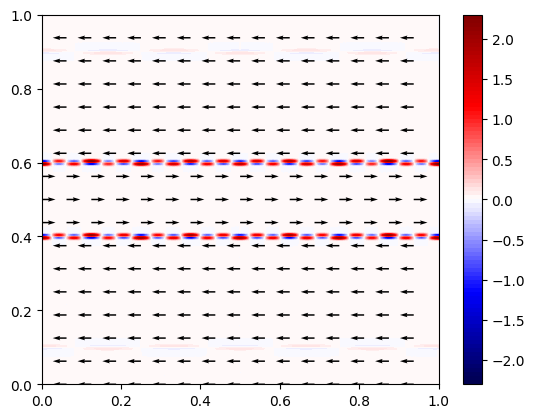

In [34]:
plot(MPS_U_quimb, MPS_V_quimb)

In [35]:
dx = 1 / (2**10-1)
Diff_2_8_x = Diff_2_8_x_MPO(10, dx)
test = MPS_U_quimb & Diff_2_8_x

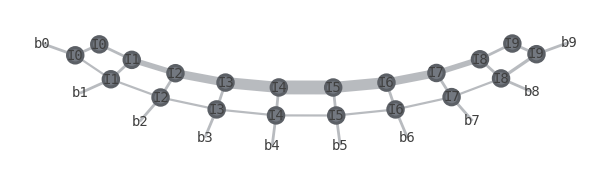

In [36]:
test.draw()

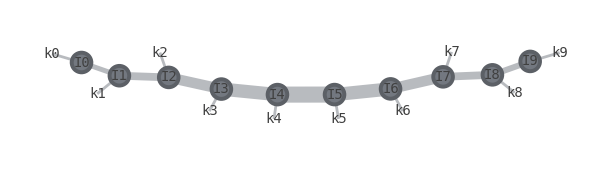

In [37]:
test_2 = Diff_2_8_x.apply(MPS_U_quimb)
test_2.draw()

In [39]:
test_2.show()

 12 48 192 768 3072 768 192 48 20 
●──●──●━━━●━━━●━━━━●━━━●━━━●──●──●
│  │  │   │   │    │   │   │  │  │


In [40]:
test_2.right_canonize()
test_2.show()

 12 48 192 768 1024 256 64 16 4 
●──<──<━━━<━━━<━━━━<━━━<──<──<─<
│  │  │   │   │    │   │  │  │ │


In [38]:
print(test_2)

MatrixProductState([
    Tensor(shape=(12, 4), inds=('_816efaAAAAA', 'k0'), tags=oset(['I0'])),
    Tensor(shape=(12, 48, 4), inds=('_816efaAAAAA', '_816efaAAAAB', 'k1'), tags=oset(['I1'])),
    Tensor(shape=(48, 192, 4), inds=('_816efaAAAAB', '_816efaAAAAC', 'k2'), tags=oset(['I2'])),
    Tensor(shape=(192, 768, 4), inds=('_816efaAAAAC', '_816efaAAAAD', 'k3'), tags=oset(['I3'])),
    Tensor(shape=(768, 3072, 4), inds=('_816efaAAAAD', '_816efaAAAAE', 'k4'), tags=oset(['I4'])),
    Tensor(shape=(3072, 768, 4), inds=('_816efaAAAAE', '_816efaAAAAF', 'k5'), tags=oset(['I5'])),
    Tensor(shape=(768, 192, 4), inds=('_816efaAAAAF', '_816efaAAAAG', 'k6'), tags=oset(['I6'])),
    Tensor(shape=(192, 48, 4), inds=('_816efaAAAAG', '_816efaAAAAH', 'k7'), tags=oset(['I7'])),
    Tensor(shape=(48, 20, 4), inds=('_816efaAAAAH', '_816efaAAAAI', 'k8'), tags=oset(['I8'])),
    Tensor(shape=(20, 4), inds=('_816efaAAAAI', 'k9'), tags=oset(['I9'])),
], L=10, max_bond=3072)


In [41]:
def hadamard_product(a_MPS, b_MPS):
    phys_dim = a_MPS.phys_dim(0)    # get the size of each physical index
    k_delta = np.zeros((phys_dim, phys_dim, phys_dim))  # initialize kronecker delta as np.array
    for i in range(phys_dim):
        k_delta[i, i, i] = 1    # only set variables to one where each index is the same
    temp_MPS = a_MPS
    for i in range(temp_MPS.L):
        delta = qu.tensor.Tensor(k_delta, inds=(f'k{i}', f'a{i}', f'b{i}'), tags=f'I{i}')   # create a kronecker delta tensor for each individual leg of the MPS
        temp_MPS = temp_MPS & delta     # connect kronecker delta tensor to MPS
        temp_MPS = temp_MPS ^ f'I{i}'   # contract kronecker delta tensor to MPS

    data = list(temp_MPS.arrays)    # convert TN to list of np.arrays in order to convert it to quimb MPO
    data[0] = data[0].transpose((1, 2, 0))   # reorder indices for first tensor (quimb speciality)
    # print(temp_MPS)
    result_MPO = qu.tensor.MatrixProductOperator(data, shape='dulr')    # create quimb MPO
    result_MPO.compress()
    b_MPS.compress()
    
    return result_MPO.apply(b_MPS, compress=True)  # return the MPO applied to the other MPS

In [42]:
def convert_ls(F):              # converts normal scalar field to scale-resolved scalar field
    Nx, Ny = F.shape            # Get number of points (Nx equals Ny)
    n = int(np.log2(Nx))        # Get number of (qu)bits
    F_vec = F.reshape((1, -1))  # Flatten function
    
    # Reshape into scale resolving representation C
    w = '0'*2*n                                 # index sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    C_vec = np.zeros(4**n).reshape((1, -1))     # similar to F but with scale indices

    for _ in range(4**n):
        F_index = get_F_index(w)                # get original index for w
        C_index = int(w, 2)                     # get corresponding index for w
        w = bin(C_index+1)[2:].zfill(2*n)       # set w += 1 in binary
        C_vec[0, C_index] = F_vec[0, F_index]   

    return C_vec.reshape((Nx, Ny))

In [43]:
def convert_back(F):            # converts scale-resolved scalar field to normal scalar field
    Nx, Ny = F.shape            # Get number of points (Nx equals Ny)
    n = int(np.log2(Nx))        # Get number of (qu)bits
    F_vec = F.reshape((1, -1))  # Flatten function
    
    # Reshape into scale resolving representation C
    w = '0'*2*n                                 # index sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    C_vec = np.zeros(4**n).reshape((1, -1))     # similar to F but with scale indices

    for _ in range(4**n):
        F_index = get_F_index(w)                # get original index for w
        C_index = int(w, 2)                     # get corresponding index for w
        w = bin(C_index+1)[2:].zfill(2*n)       # set w += 1 in binary
        C_vec[0, F_index] = F_vec[0, C_index]   

    return C_vec.reshape((Nx, Ny))

In [44]:
def get_linear_system(U, V, a_x_MPS, a_y_MPS, b_x_MPS, b_y_MPS, center, dt, Re, mu, d1x, d1y, d2x, d2y):    # get the linear system to solve the local optimization step 
    # U: MPS for velocity in x direction
    # V: MPS for velocity in y direction
    # a_x_MPS, etc. corresponds to alpha, beta of the cost function in the thesis
    # center: position of the orthogonality center
    # dt: time step
    # Re: Reynolds number
    # mu: penalty factor
    # d1x, etc.: first order derivative MPO in x direction

    U_trial = U.copy()
    V_trial = V.copy()
    
    shape = U_trial[center].shape
    N = 1
    for s in shape:
        N *= s

    A_U = np.zeros((N,N))
    A_V = np.zeros((N,N))
    b_U = np.zeros(N)
    b_V = np.zeros(N)

    for i in range(N):
        basis_tensor = np.zeros(N)
        basis_tensor[i] = 1
        basis_tensor = basis_tensor.reshape(shape)
        MPS_U_tensors = list(U_trial.arrays)
        MPS_U_tensors[center] = basis_tensor
        MPS_V_tensors = list(V_trial.arrays)
        MPS_V_tensors[center] = basis_tensor
        basis_MPS_U = qu.tensor.MatrixProductState(MPS_U_tensors)
        basis_MPS_V = qu.tensor.MatrixProductState(MPS_V_tensors)

        # without compression (syntax: ^... means contract everything)
        #A_U[i, i] = ((1 - mu*dt**2 * (basis_MPS_U & d1x.apply(d1x.apply(basis_MPS_U)) ^ ...) + (basis_MPS_U & d1x.apply(d1y.apply(basis_MPS_V)) ^ ...)))**-1
        #A_V[i, i] = ((1 - mu*dt**2 * (basis_MPS_V & d1y.apply(d1x.apply(basis_MPS_U)) ^ ...) + (basis_MPS_V & d1y.apply(d1y.apply(basis_MPS_V)) ^ ...)))**-1

        #b_U[i] = (basis_MPS_U & a_x_MPS ^ ...) - dt * (basis_MPS_U & (d2x.apply(b_x_MPS)/Re + d2y.apply(b_x_MPS)/Re + 0.5*(hadamard_product(b_x_MPS, d1x.apply(b_x_MPS)) + d1x.apply(hadamard_product(b_x_MPS, b_x_MPS)) + hadamard_product(b_y_MPS, d1y.apply(b_x_MPS)) + d1y.apply(hadamard_product(b_y_MPS, b_x_MPS)))) ^ ...)
        #b_V[i] = (basis_MPS_V & a_y_MPS ^ ...) - dt * (basis_MPS_V & (d2x.apply(b_y_MPS)/Re + d2y.apply(b_y_MPS)/Re + 0.5*(hadamard_product(b_x_MPS, d1x.apply(b_y_MPS)) + d1x.apply(hadamard_product(b_x_MPS, b_y_MPS)) + hadamard_product(b_y_MPS, d1y.apply(b_y_MPS)) + d1y.apply(hadamard_product(b_y_MPS, b_y_MPS)))) ^ ...)

        A_U[i, i] = ((1 - mu*dt**2 * (basis_MPS_U & d1x.apply(d1x.apply(basis_MPS_U, compress=True), compress=True) ^ ...) + (basis_MPS_U & d1x.apply(d1y.apply(basis_MPS_V, compress=True), compress=True) ^ ...)))**-1
        A_V[i, i] = ((1 - mu*dt**2 * (basis_MPS_V & d1y.apply(d1x.apply(basis_MPS_U, compress=True), compress=True) ^ ...) + (basis_MPS_V & d1y.apply(d1y.apply(basis_MPS_V, compress=True), compress=True) ^ ...)))**-1

        b_U[i] = (basis_MPS_U & a_x_MPS ^ ...) - dt * (basis_MPS_U & (d2x.apply(b_x_MPS, compress=True)/Re + d2y.apply(b_x_MPS, compress=True)/Re + 0.5*(hadamard_product(b_x_MPS, d1x.apply(b_x_MPS, compress=True)) + d1x.apply(hadamard_product(b_x_MPS, b_x_MPS), compress=True) + hadamard_product(b_y_MPS, d1y.apply(b_x_MPS, compress=True)) + d1y.apply(hadamard_product(b_y_MPS, b_x_MPS), compress=True))) ^ ...)
        b_V[i] = (basis_MPS_V & a_y_MPS ^ ...) - dt * (basis_MPS_V & (d2x.apply(b_y_MPS, compress=True)/Re + d2y.apply(b_y_MPS, compress=True)/Re + 0.5*(hadamard_product(b_x_MPS, d1x.apply(b_y_MPS, compress=True)) + d1x.apply(hadamard_product(b_x_MPS, b_y_MPS), compress=True) + hadamard_product(b_y_MPS, d1y.apply(b_y_MPS, compress=True)) + d1y.apply(hadamard_product(b_y_MPS, b_y_MPS), compress=True))) ^ ...)

    return A_U, A_V, b_U, b_V, shape

In [45]:
def time_evolution(U, V, dt, T, Re, mu, epsilon):   # time evolution algorithm
    n = U.L
    dx = 1 / (2**n - 1)
    # finite difference operators with 8th order precision
    # d1x = Diff_1_8_x_MPO(n, dx)
    # d1y = Diff_1_8_y_MPO(n, dx)
    # d2x = Diff_2_8_x_MPO(n, dx)
    # d2y = Diff_2_8_y_MPO(n, dx)

    # finite difference operators with 2nd order precision 
    d1x = Diff_1_2_x_MPO(n, dx)
    d1y = Diff_1_2_y_MPO(n, dx)
    d2x = Diff_2_2_x_MPO(n, dx)
    d2y = Diff_2_2_y_MPO(n, dx)

    for step in range(int(T/dt)):   # for every time step dt
        print(f"step: {step}")
        U_trial = U.copy()          # trial velocity state
        V_trial = V.copy()          # trial velocity state
        U_prev = U.copy()           # previous velocity state
        V_prev = V.copy()           # previous velocity state
        E_0 = 1e-10                 # Energy before
        E_1 = 2*epsilon             # Energy after
        rep = 0                     # repetition of sweep
        while np.abs((E_1-E_0)/E_0) > epsilon:      # do until the energy does not change anymore
            print(f"rep: {rep}, Delta: {np.abs((E_1-E_0)/E_0)}")
            rep += 1
            U_trial.right_canonize()    # bring the orthogonality center to the first tensor in U_trial
            V_trial.right_canonize()    # bring the orthogonality center to the first tensor in V_trial
            center = 0                  # thus the center is in tensor 0
            
            # sweep through MPS and optimize locally
            for i in range(n):      
                print(f"center = {i}")
                if i != center:         # shift the orthogonality center to i
                    U_trial.shift_orthogonality_center(center, i)
                    V_trial.shift_orthogonality_center(center, i)
                    center = i

                # Midpoint RK-2 step
                A_U, A_V, b_U, b_V, shape = get_linear_system(U_trial, V_trial, U_prev, V_prev, U_prev, V_prev, center, dt/2, Re, mu, d1x, d1y, d2x, d2y)   # get the linear system for local optimization (A matrices are already inverted)
                C_U = np.matmul(A_U, b_U)   # solution to linear system for velocity in x direction
                C_V = np.matmul(A_V, b_V)   # solution to linear system for velocity in y direction
                MPS_U_mid_tensors = list(U_trial.arrays)        # get all tensors as list of numpy arrays
                MPS_U_mid_tensors[center] = C_U.reshape(shape)  # update the tensor of the orthogonality center with solution of linear system
                U_mid = qu.tensor.MatrixProductState(MPS_U_mid_tensors) # save midpoint field as quimb MPS
                MPS_V_mid_tensors = list(V_trial.arrays)
                MPS_V_mid_tensors[center] = C_V.reshape(shape)
                V_mid = qu.tensor.MatrixProductState(MPS_V_mid_tensors) # save midpoint field as quimb MPS

                # Full RK-2 step
                A_U, A_V, b_U, b_V, shape = get_linear_system(U_trial, V_trial, U_prev, V_prev, U_mid, V_mid, center, dt, Re, mu, d1x, d1y, d2x, d2y)   # get the linear system for local optimization (A matrices are already inverted)
                C_U = np.matmul(A_U, b_U)
                C_V = np.matmul(A_V, b_V)
                MPS_U_tensors = list(U_trial.arrays)
                MPS_U_tensors[center] = C_U.reshape(shape)
                U_trial = qu.tensor.MatrixProductState(MPS_U_mid_tensors)   # save velocity field after full time step
                MPS_V_tensors = list(V_trial.arrays)
                MPS_V_tensors[center] = C_V.reshape(shape)
                V_trial = qu.tensor.MatrixProductState(MPS_V_mid_tensors)   # save velocity field after full time step

            # sweep back through MPS and optimize locally
            for i in range(n-2, -1, -1):
                print(f"center = {i}")
                if i != center:         # shift the orthogonality center to i
                    U_trial.shift_orthogonality_center(center, i)
                    V_trial.shift_orthogonality_center(center, i)
                    center = i

                # Midpoint RK-2 step
                A_U, A_V, b_U, b_V, shape = get_linear_system(U_trial, V_trial, U_prev, V_prev, U_prev, V_prev, center, dt/2, Re, mu, d1x, d1y, d2x, d2y)
                C_U = np.matmul(A_U, b_U)
                C_V = np.matmul(A_V, b_V)
                MPS_U_mid_tensors = list(U_trial.arrays)
                MPS_U_mid_tensors[center] = C_U.reshape(shape)
                U_mid = qu.tensor.MatrixProductState(MPS_U_mid_tensors)
                MPS_V_mid_tensors = list(V_trial.arrays)
                MPS_V_mid_tensors[center] = C_V.reshape(shape)
                V_mid = qu.tensor.MatrixProductState(MPS_V_mid_tensors)

                # Full RK-2 step
                A_U, A_V, b_U, b_V, shape = get_linear_system(U_trial, V_trial, U_prev, V_prev, U_mid, V_mid, center, dt, Re, mu, d1x, d1y, d2x, d2y)
                C_U = np.matmul(A_U, b_U)
                C_V = np.matmul(A_V, b_V)
                MPS_U_tensors = list(U_trial.arrays)
                MPS_U_tensors[center] = C_U.reshape(shape)
                U_trial = qu.tensor.MatrixProductState(MPS_U_mid_tensors)
                MPS_V_tensors = list(V_trial.arrays)
                MPS_V_tensors[center] = C_V.reshape(shape)
                V_trial = qu.tensor.MatrixProductState(MPS_V_mid_tensors)

            # After sweeping back and forth, save the resulting MPS as new U and V
            U = U_trial.copy()
            V = V_trial.copy()
            
            E_0 = E_1                                                       # set the previous "Energy" to E_0
            E_1 = (U_trial & U_trial ^ ...) + (V_trial & V_trial ^ ...)     # calculate the new "Energy" from new states
        plot(U, V, full=True)
        
    return U, V

In [46]:
def build2DExampleMPS(n_bits, L, chi, T): # flexible creation of initial MPS
    # Create field
    N = 2**n_bits

    # Initial conditions
    y_min = 0.4
    y_max = 0.6
    h = 1/200 
    u_max = 1
    epsilon = 10^-8

    # Set timesteps
    dt = 0.1*2**-(n_bits-1)

    # Set penalty factor for breach of incompressibility condition
    dx = 2**-n_bits-1
    lam = dx**2 * 10**4

    # Generate initial fields
    U, V = CreateFields2D(L, N, y_min, y_max, h, u_max) 

    # Rescale into non-dimensional units
    U = U/u_max
    V = V/u_max

    # Convert them to MPS form
    MPS_U = convert_to_MPS2D(U, chi)
    MPS_V = convert_to_MPS2D(V, chi)

    # Tranform into quimb MPS form
    MPS_U_quimb = convert_MPS_to_quimb(MPS_U, 4)
    MPS_V_quimb = convert_MPS_to_quimb(MPS_V, 4)

    return MPS_U_quimb, MPS_V_quimb, MPS_U, MPS_V

In [47]:
# Create field
n_bits = 3
n = n_bits
N = 2**n_bits
L = 1
chi = N

# Initial conditions
y_min = 0.4
y_max = 0.6
h = 1/200 
u_max = 1
epsilon = 1e-3

# Set timesteps
dt = 0.1*2**-(n_bits-1)
T = 10

# Set penalty factor for breach of incompressibility condition
dx = 2**-n_bits-1
lam = dx**2 * 10**4
Re = 200*1e3

In [48]:
U_init, V_init, U_init_, V_init_ = build2DExampleMPS(n_bits, L, chi, T)

step: 0
rep: 0, Delta: 19999999.0
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 1, Delta: 31.370073774768017
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 2, Delta: 0.008604187007078422
center = 0
center = 1
center = 2
center = 1
center = 0


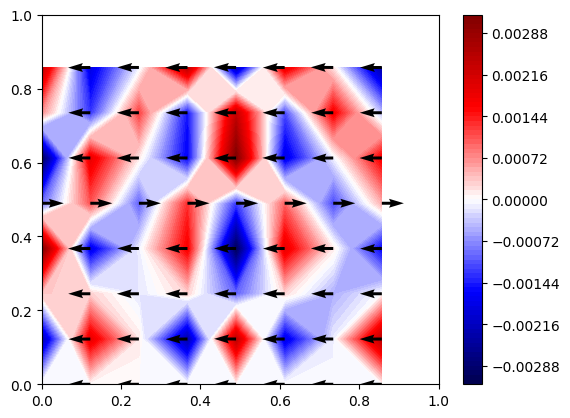

step: 1
rep: 0, Delta: 19999999.0
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 1, Delta: 0.8666921777428198
center = 0
center = 1
center = 2
center = 1
center = 0


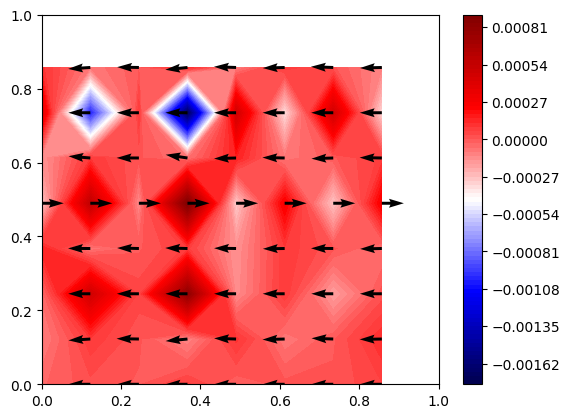

step: 2
rep: 0, Delta: 19999999.0
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 1, Delta: 0.9994328213538581
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 2, Delta: 0.02158723363405986
center = 0
center = 1
center = 2
center = 1
center = 0


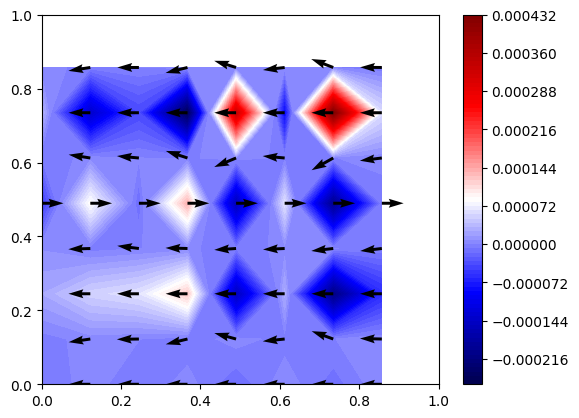

step: 3
rep: 0, Delta: 19999999.0
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 1, Delta: 0.9999896344164512
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 2, Delta: 0.17664716229810923
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 3, Delta: 0.4706158029805399
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 4, Delta: 0.47531479754400935
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 5, Delta: 0.7837432649700696
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 6, Delta: 0.032572616509266655
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 7, Delta: 0.003712281690609679
center = 0
center = 1
center = 2
center = 1
center = 0


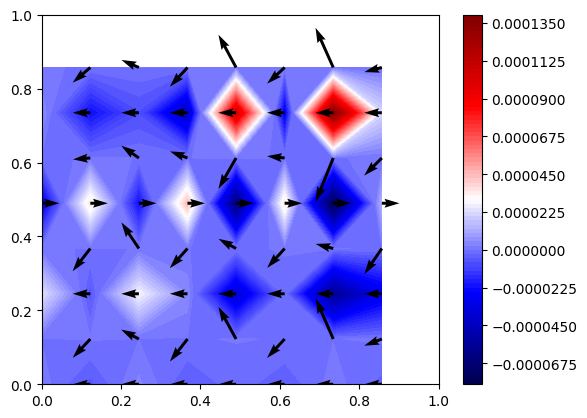

step: 4
rep: 0, Delta: 19999999.0
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 1, Delta: 0.9999987639621569
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 2, Delta: 0.32271530050845976
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 3, Delta: 9.331490948393606
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 4, Delta: 0.9830794568038747
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 5, Delta: 0.004167110217638867
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 6, Delta: 0.009929172687967785
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 7, Delta: 0.006589095476057763
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 8, Delta: 0.005256451732863954
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 9, Delta: 0.0049273421141132895
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 10, Delta: 0.004880733681078947
center = 0
center = 1
center = 2
center = 1
center = 0
rep: 11

KeyboardInterrupt: 

In [361]:
U_test, V_test = time_evolution(U_init, V_init, dt, T, Re, lam, epsilon)

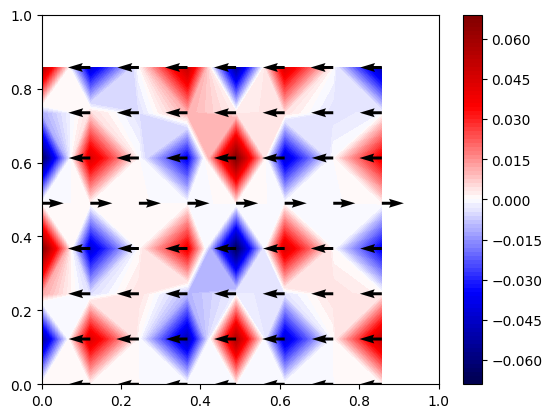

In [352]:
plot(U_init, V_init, full=True)